# Example on how to use Python to read the output files from ASPECT.

We start by importing the packages needed and the functions from the file read_files.py:

In [1]:
%matplotlib inline  
## This allows figures to be plotted "inline". 
## In a normal python script, you use plt.show() to see the figures, 
## or plt.savefig("name.pdf") to save the figures 
## (you can also use this command in the notebooks)

import numpy as np  # for mathematical functions and arrays
import matplotlib.pyplot as plt  # for plot
import pandas as pd # for data analysis
from scipy.interpolate import griddata
## We use short names for the libraries we use a lot.

import io 
import os
from subprocess import run

import aspect_data

# Running aspect from the notebook 

You may want to modify the path for the aspect build folder. 

A run will provide the output files that we are then reading later. 

In [34]:
input_file = "convection-box.prm"     
aspect_bin = "../../build/aspect"          # Path to aspect executable
output_dir = "./output/"                      # Output directory

def run_aspect():
    run(['rm','-rf',output_dir])
    run([aspect_bin,input_file])
    
run_aspect()

# Parameter file

Sometimes, it's useful to be able to access the values for the parameters inside the parameter file, especially if you are exploring a large parameter space. 

You can read the parameter file with the function read_files.read_parameter_file(filename)

In [26]:
param_file = output_dir+"parameters.prm"
param = aspect_data.read_parameter_file(param_file)

The param variable is then a dictionnary that include all the parameters that have been defined in the original parameter file. One can then access the values using the same names than the subsections in the .prm file. 

In [27]:
print(param["Material model"])
print(param["Material model: Simple model"])

{'Material averaging': ['none'], 'Model name': ['simple']}
{'Composition viscosity prefactor': ['1.0'], 'Density differential for compositional field 1': ['0'], 'Maximum thermal prefactor': ['1.0e2'], 'Minimum thermal prefactor': ['1.0e-2'], 'Reference density': ['1'], 'Reference specific heat': ['1'], 'Reference temperature': ['0'], 'Thermal conductivity': ['1'], 'Thermal expansion coefficient': ['1'], 'Thermal viscosity exponent': ['0.0'], 'Viscosity': ['1']}


## File statistics

The file statistics regroup all the statistics for everytime steps. It can be a very long file, so pandas (a package for data analysis) is the best tool to open and read it. 
The number of columns depends on your run, and is indicated as comments at the beginning of the file. The function read_statistics() will first read the comments, extracts the names of the columns and then read the file with pd.read_csv(). 

Here, we use an example of a run with a 1D column. All the output files are in the folder ./example. 

In [28]:
# we provide the name for the file statistics:
statistics = output_dir+ "statistics"

# we read the file with our function:
data =  aspect_data.read_statistics(statistics)

The output of the function is a pandas dataframe, where all datas are in a big table where the columns have human-readable names. We can have a look at the table wit data.head()

In [29]:
data.head()

,Time step number,Time (seconds),Time step size (seconds),Number of mesh cells,Number of Stokes degrees of freedom,Number of temperature degrees of freedom,Iterations for temperature solver,Iterations for Stokes solver,Velocity iterations in Stokes preconditioner,Schur complement iterations in Stokes preconditioner,...,Max. velocity (m/s),Minimal temperature (K),Average temperature (K),Maximal temperature (K),Average nondimensional temperature (K),"Outward heat flux through boundary with indicator 0 (""left"") (W)","Outward heat flux through boundary with indicator 1 (""right"") (W)","Outward heat flux through boundary with indicator 2 (""bottom"") (W)","Outward heat flux through boundary with indicator 3 (""top"") (W)",Visualization file name
0,0,0.000000,0.000000,256,2467,1089,0,31,33,32,...,2.531770,0.0,0.5,1.0,0.5,0.0,0.0,-1.000000,1.000000,output/solution/solution-00000
1,1,0.012337,0.012337,256,2467,1089,31,32,34,34,...,8.377950,0.0,0.5,1.0,0.5,0.0,0.0,-1.006876,1.006876,output/solution/solution-00001
2,2,0.016065,0.003728,256,2467,1089,20,31,33,33,...,15.479564,0.0,0.5,1.0,0.5,0.0,0.0,-1.023201,1.023201,NaN
3,3,0.018083,0.002018,256,2467,1089,15,30,32,32,...,22.948809,0.0,0.5,1.0,0.5,0.0,0.0,-1.048978,1.048978,NaN
4,4,0.019444,0.001361,256,2467,1089,13,29,31,31,...,30.430303,0.0,0.5,1.0,0.5,0.0,0.0,-1.084120,1.084120,NaN


We can then look at the evolution of some of the statistics with time: 

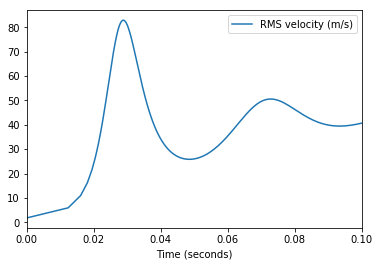

In [30]:
# using the plot function embedded in the panda frame:
data.plot("Time (seconds)", "RMS velocity (m/s)")

Text(0.5, 0, 'Time (s)')

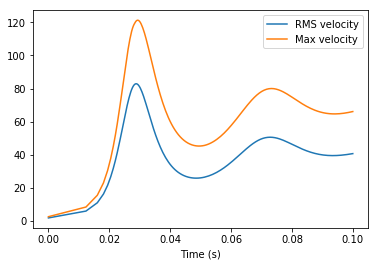

In [31]:
# or using the pyplot functions (allows more flexibility)

fig, ax = plt.subplots()

ax.plot(data["Time (seconds)"], data["RMS velocity (m/s)"], label="RMS velocity")
ax.plot(data["Time (seconds)"], data["Max. velocity (m/s)"], label="Max velocity")
ax.legend()
ax.set_xlabel("Time (s)")

## Visualization files

The statistics file includes when visualization files have been created. If they have been written as gnuplot files, then we can read them and plot them. 

In the example case, the grid is a column of 1 cell width. So the output can be plotted as 1D variable. 

In [32]:
# we remove the values from data with NaN in the visualization file name column
data = data.dropna(subset=["Visualization file name"])

# we store the values for the file names and the associated time. 
visu_files = data["Visualization file name"].values
visu_times = data["Time (seconds)"].values

df = aspect_data.read_gnuplot_visu(visu_files[0]+".0000.gnuplot")
print(df.head())

FileNotFoundError: [Errno 2] No such file or directory: 'output/solution/solution-00000.0000.gnuplot'

### Unstructured grid 

The points are not always on a structured grid, so tricontourf may be the best way to plot the temperature field for example

FileNotFoundError: [Errno 2] No such file or directory: 'output/solution/solution-00000.0000.gnuplot'

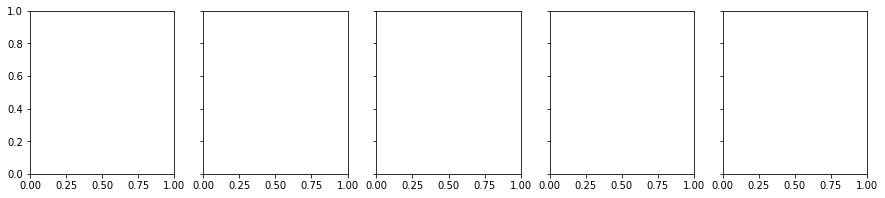

In [33]:
fig, ax = plt.subplots(1, 5, sharey=True, sharex=True, figsize=[15,3])

i=0
for time, file in zip(visu_times[:-2:2], visu_files[:-2:2]):
    #print(time, file)
    file = file+".0000.gnuplot"
    df = aspect_data.read_gnuplot_visu(file)
    #df = df[df["x"]==0.5]
    x, y, t = df["x"].values, df["y"].values, df["T"].values
    ax[i].tricontourf(x, y, t, 15, vmin=0, vmax=1)
    i += 1

### Structured grid 

However, for plotting the velocities, it may be easier to interpolate on a structured grid, using griddata from scipy.

This also allows to use streamplots, for example. 

In that case, we choose where the points will be interpolated, which may be better in the case of very asymetric x/y axis (for example if one axis in log scale and not the other)

(0.0, 1.0, 0.0, 1.0)

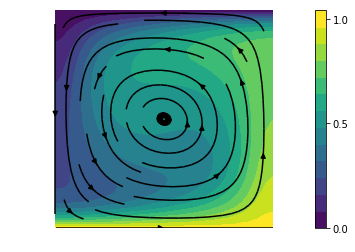

In [21]:
fig, ax = plt.subplots()

# define grid.
xi = np.linspace(0, 1, 100)
yi = np.linspace(0, 1, 100)
xi, yi = np.meshgrid(xi, yi)

# interpolate the values on the grid for the temperature.
Ti = griddata((x, y), t, (xi, yi))
# contour the gridded data, plotting dots at the nonuniform data points.
#CS = plt.contour(xi, yi, Ti, 15, linewidths=0.5, colors='k')
CS = ax.contourf(xi, yi, Ti, 15,
                  vmax=1., vmin=0.)
fig.colorbar(CS, ax=ax, ticks=[0, 0.5, 1])

# grid the velocities
vx, vy = df["velocity_x"].values, df["velocity_y"].values
Vxi = griddata( (x, y), vx, (xi, yi))
Vyi = griddata( (x, y), vy, (xi, yi))
ax.streamplot(xi, yi, Vxi, Vyi, density=[0.5,0.5], color='k')

ax.axis('equal')  # force the x and y axes to have the same scale
ax.set_xlim([0,1])
ax.set_ylim([0,1])
ax.axis('off') # remove the axes and ticks